In [2]:

import pandas as pd
import numpy as np


from sklearn.model_selection import KFold
#MODEL auch mit nicht zeitabhägigen Features




In [3]:
pd.set_option('display.max_columns', None)


In [4]:
import sys
print(sys.version)

3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]


In [5]:
!nvidia-smi

Wed Sep  6 21:44:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:41:00.0 Off |                    0 |
|  0%   32C    P0    76W / 300W |      0MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:A1:00.0 Off |                    0 |
|  0%   

In [6]:
import sys
sys.version

'3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]'

In [7]:
import pandas as pd

def shift_column(df, column_to_shift, shift_amount, group_identifier):
    """
    Shifts a column in a pandas dataframe by a specified amount within a certain group.
    
    Parameters:
    df: pandas.DataFrame
        The DataFrame on which to operate
    column_to_shift: str
        The name of the column to shift
    shift_amount: int
        The amount by which to shift the column
    group_identifier: str
        The name of the column to group by before shifting
    
    Returns:
    pandas.DataFrame
        The DataFrame with the shifted column
    """
    
    df[f"{column_to_shift}_shifted_by_{shift_amount}"] = df.groupby(group_identifier)[column_to_shift].shift(shift_amount)
    
    return df


In [8]:
def train_test_split(df, key = 'rand_id', test_size=0.1):
    unique_case_id = df[key].drop_duplicates().tolist()
    ind = int(len(unique_case_id )*(1-test_size))
    print(ind)
    split_index = unique_case_id[ind]
    print(split_index)
    first_entry_index = df.loc[df[ key] == split_index].index[0]
    print(first_entry_index)
    train_df = df.iloc[:first_entry_index]
    test_df = df.iloc[first_entry_index:]
    return train_df, test_df

In [9]:
def insert_rows(group, num_rows):
    case_id = group.iloc[0]["rand_id"]
    for _ in range(num_rows):
        new_row = pd.DataFrame({'rand_id': case_id}, index=[-1])
        new_row[new_row.columns[1:]] = 0
        group = pd.concat([new_row, group]).reset_index(drop=True)
    return group



In [10]:
def shift_and_one_hot_fill(df, label, shifts=[]):
    
    ls = list(shifts)
    
    for i in ls:      
        new_col = shift_index(df, label, i)[label].copy()
        df[f'{prefix}_{i}_'+label] = new_col.astype('float32')
    for i in ls:
        for j in ls:
            if(j<i):
                df[f'{prefix}_{j}_'+label] = np.where(df[f'{prefix}_{i}_'+label] > 0, 0, df[f'{prefix}_{j}_'+label])
    return df

In [11]:
def shift_and_one_hot(df, label, shifts=[]):
    
    ls = list(shifts)
    
    for i in ls:      
        shift_column(df, label, i, 'rand_id')

    return df

In [12]:

def shifted_label_names(label, shifts=[]):
    ls = list(shifts)
    names = []
    for ele in ls:
        names.append(f"{label}_shifted_by_{ele}")
    return names



In [13]:
def add_negative_col(df, label_names, label):
    df['no_'+label] = 1. 
    labels = ['no_'+label]
    for ele in label_names:
        df['no_'+label] = np.where(df[ele] > 0, 0, df['no_'+label])
        labels.append(ele)
        
    return df, labels

In [14]:
def replace_task(df, columnn, old, new):
    return df[columnn].replace(old, new, regex=True)

def replace_string_data(df,  replace_data):
    for i, (column, old, new) in enumerate(replace_data):
        print(column)
        print(old)
        print(new)
        df[column] = replace_task(df, column, old, new)
    return df 



In [15]:
replace_data = [[['phase'],['pre-surgery','pre-airway','intra-surgery', 'post-surgery', 'undefined'],  [0,0.33,0.66,1,0.66]]]

In [16]:
time_variables = ['hf', 'pulse', 'spo2', 'etco2', 'systolicbp',
       'diastolicbp', 'meanbp', 'invasivebp', 'insevo', 'exsevo', 'indes',
       'exdes', 'berodual', 'cisatracurium', 'esketamin', 'etomidat',
       'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid',
       'propofol', 'remifentanil', 'rocuronium', 'succinylcholin',
       'sufentanil', 'compliance', 'fio2', 'peep', 'plateau', 'pmax', 'ppeak',
       'pmean', 'resistance', 'ventfreq', 'ventmode', 'vt',
       'dobutamin_perfusor', 'epinephrin_perfusor', 'levosimendan_perfusor',
       'noradrenalin_perfusor', 'phenylephrin_perfusor', 'propofol_perfusor',
       'remifentanil_perfusor', 'sufentanil_perfusor', 'vasopressin_perfusor',
       'phase'] 

additional_features = ['case_time', 'age', 'gender', 'asa_score', 'urgency','surgery_type']


both_features = ['hf', 'pulse', 'spo2', 'etco2', 'systolicbp',
       'diastolicbp', 'meanbp', 'invasivebp', 'insevo', 'exsevo', 'indes',
       'exdes', 'berodual', 'cisatracurium', 'esketamin', 'etomidat',
       'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid',
       'propofol', 'remifentanil', 'rocuronium', 'succinylcholin',
       'sufentanil', 'compliance', 'fio2', 'peep', 'plateau', 'pmax', 'ppeak',
       'pmean', 'resistance', 'ventfreq', 'ventmode', 'vt',
       'dobutamin_perfusor', 'epinephrin_perfusor', 'levosimendan_perfusor',
       'noradrenalin_perfusor', 'phenylephrin_perfusor', 'propofol_perfusor',
       'remifentanil_perfusor', 'sufentanil_perfusor', 'vasopressin_perfusor',
       'phase', 'case_time', 'age', 'gender', 'asa_score', 'urgency','surgery_type'] 

labels = ['hypotension60', 'hypotension55', 'hypotension65', 'hypoxemia']

In [17]:
all = ['rand_id', 'case_time', 'age', 'gender', 'asa_score', 'urgency',
       'surgery_type', 'hf', 'pulse', 'spo2', 'etco2', 'systolicbp',
       'diastolicbp', 'meanbp', 'invasivebp', 'insevo', 'exsevo', 'indes',
       'exdes', 'berodual', 'cisatracurium', 'esketamin', 'etomidat',
       'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid',
       'propofol', 'remifentanil', 'rocuronium', 'succinylcholin',
       'sufentanil', 'compliance', 'fio2', 'peep', 'plateau', 'pmax', 'ppeak',
       'pmean', 'resistance', 'ventfreq', 'ventmode', 'vt',
       'dobutamin_perfusor', 'epinephrin_perfusor', 'levosimendan_perfusor',
       'noradrenalin_perfusor', 'phenylephrin_perfusor', 'propofol_perfusor',
       'remifentanil_perfusor', 'sufentanil_perfusor', 'vasopressin_perfusor',
       'phase', 'hypotension60', 'hypotension65',  'hypoxemia']

In [22]:
df = pd.read_parquet('/gpfs/data/fs71801/lkapral66/featureset_20230809_shuffled.parquet')

In [19]:
df = df.head(5000000)

In [20]:
replace_data_ = [[['phase'],['pre-surgery','pre-airway','intra-surgery', 'post-surgery', 'undefined'], [0,0.33,0.66,1,0.66]], [['invasivebp'],[ True, False], [1,0]], [['hypotension65'],[ True, False], [1,0]]]

In [21]:
df

,rand_id,case_time,age,gender,asa_score,urgency,surgery_type,hf,pulse,spo2,etco2,systolicbp,diastolicbp,meanbp,invasivebp,insevo,exsevo,indes,exdes,berodual,cisatracurium,esketamin,etomidat,fentanyl,midazolam,noradrenalin,phenylephrin,piritramid,propofol,remifentanil,rocuronium,succinylcholin,sufentanil,compliance,fio2,peep,plateau,pmax,ppeak,pmean,resistance,ventfreq,ventmode,vt,dobutamin_perfusor,epinephrin_perfusor,levosimendan_perfusor,noradrenalin_perfusor,phenylephrin_perfusor,propofol_perfusor,remifentanil_perfusor,sufentanil_perfusor,vasopressin_perfusor,phase,hypotension60,MAP_period_id60,hypotension55,MAP_period_id55,hypotension65,MAP_period_id65,spo2_below_threshold,spo2_period_id,hypoxemia
0,98726471,-45,28,0,1,1,3,104.0,104.0,98.0,NaN,149.0,82.0,101,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pre-airway,0,1,0,1,0,1,0,1,0
1,98726471,-30,28,0,1,1,3,102.0,102.0,96.0,NaN,148.0,81.0,102,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pre-airway,0,1,0,1,0,1,0,1,0
2,98726471,-15,28,0,1,1,3,106.0,106.0,97.0,NaN,148.0,80.0,103,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pre-airway,0,1,0,1,0,1,0,1,0
3,98726471,0,28,0,1,1,3,123.0,127.0,98.0,NaN,147.0,79.0,104,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pre-airway,0,1,0,1,0,1,0,1,0
4,98726471,15,28,0,1,1,3,98.0,96.0,99.0,NaN,146.0,77.0,106,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pre-airway,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,69284394,2070,65,1,2,1,1,45.0,45.0,100.0,43.0,108.0,61.0,80,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,290.0,1.0,0.0,0.0,intra-surgery,0,3,0,1,0,3,0,1,0
4999996,69284394,2085,65,1,2,1,1,45.0,45.0,100.0,43.0,108.0,61.0,80,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,290.0,1.0,0.0,0.0,intra-surgery,0,3,0,1,0,3,0,1,0
4999997,69284394,2100,65,1,2,1,1,45.0,45.0,100.0,43.0,108.0,61.0,80,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,290.0,1.0,0.0,0.0,intra-surgery,0,3,0,1,0,3,0,1,0
4999998,69284394,2115,65,1,2,1,1,45.0,45.0,100.0,43.0,108.0,61.0,80,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,290.0,1.0,0.0,0.0,intra-surgery,0,3,0,1,0,3,0,1,0


In [22]:
df = replace_string_data(df, replace_data)

['phase']
['pre-surgery', 'pre-airway', 'intra-surgery', 'post-surgery', 'undefined']
[-2, -1, 0, 1, 0]


In [23]:
all = ['rand_id', 'case_time', 'age', 'gender', 'asa_score', 'urgency',
       'surgery_type', 'hf', 'pulse', 'spo2', 'etco2', 'systolicbp',
       'diastolicbp', 'meanbp', 'invasivebp', 'insevo', 'exsevo', 'indes',
       'exdes', 'berodual', 'cisatracurium', 'esketamin', 'etomidat',
       'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid',
       'propofol', 'remifentanil', 'rocuronium', 'succinylcholin',
       'sufentanil', 'compliance', 'fio2', 'peep', 'plateau', 'pmax', 'ppeak',
       'pmean', 'resistance', 'ventfreq', 'ventmode', 'vt',
       'dobutamin_perfusor', 'epinephrin_perfusor', 'levosimendan_perfusor',
       'noradrenalin_perfusor', 'phenylephrin_perfusor', 'propofol_perfusor',
       'remifentanil_perfusor', 'sufentanil_perfusor', 'vasopressin_perfusor',
       'phase', 'hypotension60', 'hypotension65',  'hypoxemia']

raw_data_kor = pd.read_parquet('/gpfs/data/fs71801/lkapral66/exportVitalDB_all_V2.parquet')
df_kor = raw_data_kor
replace_data_kor = [ [['phase'],['pre-surgery','pre-airway','intra-surgery', 'post-surgery', 'undefined'], [0,0.33,0.66,1,0.66]], [['invasivebp'],[ 'NIBP', 'ART'], [False,True]], [['hypotension60'],[ 0, 1], [False,True]], [['hypotension65'],[ 0, 1], [False,True]], [['hypoxemia'],[ 0, 1], [False,True]]]

df_kor['case_time'] = df_kor['case_time'].dt.hour * 3600 + df_kor['case_time'].dt.minute * 60 + df_kor['case_time'].dt.second
df_kor[['berodual', 'cisatracurium', 'esketamin', 'etomidat', 'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid', 'propofol', 'remifentanil', 'rocuronium', 'succinylcholin', 'sufentanil', 'pmax', 'resistance', 'ventfreq', 'ventmode', 'vt', 'dobutamin_perfusor', 'levosimendan_perfusor', 'sufentanil_perfusor']]=0.

df_kor = df_kor[df_kor['asa_score'].isin([1,2,3,4,5])]
df_kor = df_kor.loc[df_kor['surgery_type']!=16,:]
df_kor = df_kor[all]
df_kor.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

# Step 1: Identify columns with non-finite values
columns_with_non_finite = df_kor.columns[df_kor.isin([np.nan, np.inf, -np.inf]).any()]

# Step 2: Handle non-finite values (e.g., replace with 0)
df_kor[columns_with_non_finite] = df_kor[columns_with_non_finite].fillna(0)

# Step 3: Convert columns to integer dtype
for column in columns_with_non_finite:
    df_kor[column] = df_kor[column].astype(int)

df_kor = replace_string_data(df_kor, replace_data_kor)


for column in df.columns:
    if column in df_kor.columns:
        df_kor[column] = df_kor[column].astype(df[column].dtype)









numeric_columns = df_kor.select_dtypes(include=[np.number])
df_kor[numeric_columns.columns] = numeric_columns.fillna(method='ffill').fillna(0.0)









['phase']
['pre-surgery', 'pre-airway', 'intra-surgery', 'post-surgery', 'undefined']
[0, 0.33, 0.66, 1, 0.66]
['invasivebp']
['NIBP', 'ART']
[False, True]
['hypotension60']
[0, 1]
[False, True]
['hypotension65']
[0, 1]
[False, True]
['hypoxemia']
[0, 1]
[False, True]


In [24]:
df_kor.columns

Index(['rand_id', 'case_time', 'age', 'gender', 'asa_score', 'urgency',
       'surgery_type', 'hf', 'pulse', 'spo2', 'etco2', 'systolicbp',
       'diastolicbp', 'meanbp', 'invasivebp', 'insevo', 'exsevo', 'indes',
       'exdes', 'berodual', 'cisatracurium', 'esketamin', 'etomidat',
       'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid',
       'propofol', 'remifentanil', 'rocuronium', 'succinylcholin',
       'sufentanil', 'compliance', 'fio2', 'peep', 'plateau', 'pmax', 'ppeak',
       'pmean', 'resistance', 'ventfreq', 'ventmode', 'vt',
       'dobutamin_perfusor', 'epinephrin_perfusor', 'levosimendan_perfusor',
       'noradrenalin_perfusor', 'phenylephrin_perfusor', 'propofol_perfusor',
       'remifentanil_perfusor', 'sufentanil_perfusor', 'vasopressin_perfusor',
       'phase', 'hypotension60', 'hypotension65', 'hypoxemia'],
      dtype='object')

In [25]:
df.columns

Index(['rand_id', 'case_time', 'age', 'gender', 'asa_score', 'urgency',
       'surgery_type', 'hf', 'pulse', 'spo2', 'etco2', 'systolicbp',
       'diastolicbp', 'meanbp', 'invasivebp', 'insevo', 'exsevo', 'indes',
       'exdes', 'berodual', 'cisatracurium', 'esketamin', 'etomidat',
       'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid',
       'propofol', 'remifentanil', 'rocuronium', 'succinylcholin',
       'sufentanil', 'compliance', 'fio2', 'peep', 'plateau', 'pmax', 'ppeak',
       'pmean', 'resistance', 'ventfreq', 'ventmode', 'vt',
       'dobutamin_perfusor', 'epinephrin_perfusor', 'levosimendan_perfusor',
       'noradrenalin_perfusor', 'phenylephrin_perfusor', 'propofol_perfusor',
       'remifentanil_perfusor', 'sufentanil_perfusor', 'vasopressin_perfusor',
       'phase', 'hypotension60', 'MAP_period_id60', 'hypotension55',
       'MAP_period_id55', 'hypotension65', 'MAP_period_id65',
       'spo2_below_threshold', 'spo2_period_id', 'hypoxemia'],
  

In [26]:
shifts = [0,-4,-12,-20,-28] #0,1,3,5,7

In [27]:
#df['hypotension65'] = int(df['meanbp']<65.)

In [28]:
label= 'hypotension65'
label_names = shifted_label_names(label, shifts=shifts)

In [29]:
df = shift_and_one_hot(df, label, shifts)

In [30]:
df_kor = shift_and_one_hot(df_kor, label, shifts)

In [65]:
window_size_xgb = 16 # 2 minutes / 15 seconds
shift_index = 3
kor = False

In [66]:
import numpy as np

def make_dataset(df, shifts):
    features = df[both_features]
    prediction_time = shifts[shift_index]
    original_features = []
    
    labels = []
    data = []
    for id_, group in df.groupby('rand_id'):
        # drop the id column
        group = group.drop('rand_id', axis=1)
        features = group[both_features].values
        label = group[label_names[shift_index]].values
        
        for i in range(window_size_xgb, len(group)):
            # select the rows for the current window
            window_data = features[i-window_size_xgb:i].flatten()
            data.append(window_data)
            
            # select the label for the current window
            # this selects the label of the last row in the window
            # change this if you want to determine the label in a different way
            window_label = label[i-1]
            labels.append(window_label)
            
                    # select the last value of the original feature in the window
            original_feature_value = group['meanbp'].values[i-1]
            original_features.append(original_feature_value)
    
    # convert the lists of arrays into 2D arrays
    data = np.array(data)
    labels = np.array(labels)
    original_features = np.array(original_features)


    not_nan_indices = np.logical_not(np.isnan(labels))
    
    # Use these indices to get the non-NaN labels and corresponding data
    labels = labels[not_nan_indices]
    data = data[not_nan_indices]
    original_features = original_features[not_nan_indices]

    return labels, data, original_features

In [67]:
if(kor):
    labels, data, original_features = make_dataset(df_kor, shifts)   
else:
    labels, data, original_features = make_dataset(df, shifts)    

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
import xgboost as xgb

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42, shuffle= True)

# Assume you have X, y as your data and target
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


class_ratio = float(np.sum(labels == 0)) / np.sum(labels == 1)
# Train XGBoost



In [69]:
'''
model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 64, alpha = 10, n_estimators = 500, scale_pos_weight=class_ratio)
model.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
model = calibrator.fit(X_val, y_val)

import pickle

# Assuming 'clf' is your trained CalibratedClassifierCV model
with open('XGB_'+str(shifts[shift_index])+'.pkl', 'wb') as f:
    pickle.dump(model, f)
'''

"\nmodel = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,\n                max_depth = 64, alpha = 10, n_estimators = 500, scale_pos_weight=class_ratio)\nmodel.fit(X_train, y_train)\ncalibrator = CalibratedClassifierCV(model, cv='prefit', method='isotonic')\nmodel = calibrator.fit(X_val, y_val)\n\nimport pickle\n\n# Assuming 'clf' is your trained CalibratedClassifierCV model\nwith open('XGB_'+str(shifts[shift_index])+'.pkl', 'wb') as f:\n    pickle.dump(model, f)\n"

In [70]:

import pickle

with open('XGB_'+str(shifts[shift_index])+'.pkl', 'rb') as f:
    model = pickle.load(f)




In [71]:
# use the model to make predictions on the test set
y_pred = model.predict(X_test)

# compute the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.942228277781983


In [72]:
original_features.shape

(3566969,)

In [73]:
X_test.shape

(356697, 848)

In [74]:
y_pred.shape

(356697,)

In [75]:
len(both_features)

53

In [76]:
show_index = 6

In [77]:
data[927:932,[show_index, show_index+len(both_features)*1, show_index+len(both_features)*2, show_index+len(both_features)*3,show_index+len(both_features)*4, show_index+len(both_features)*5, show_index+len(both_features)*6, show_index+len(both_features)*7, show_index+len(both_features)*8, show_index+len(both_features)*9, show_index+len(both_features)*10, show_index+len(both_features)*11, show_index+len(both_features)*12, show_index+len(both_features)*13, show_index+len(both_features)*14, show_index+len(both_features)*15]]

array([[86., 67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 62., 62.,
        62., 62., 62.],
       [67., 67., 67., 67., 67., 67., 67., 67., 67., 67., 62., 62., 62.,
        62., 62., 62.],
       [67., 67., 67., 67., 67., 67., 67., 67., 67., 62., 62., 62., 62.,
        62., 62., 62.],
       [67., 67., 67., 67., 67., 67., 67., 67., 62., 62., 62., 62., 62.,
        62., 62., 62.],
       [67., 67., 67., 67., 67., 67., 67., 62., 62., 62., 62., 62., 62.,
        62., 62., 62.]])

In [78]:
labels[6400:6600]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [79]:
original_features[927:970]

array([ 62,  62,  62,  62,  62,  70,  70,  70,  70,  70,  70,  70,  70,
        70,  70,  70,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
        77,  77,  77,  77,  77,  77,  77,  77,  77,  77, 103, 103, 103,
       103, 103, 103, 103])

In [80]:
model.predict(data[927:970,:])

array([1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

(400,)
(400, 848)


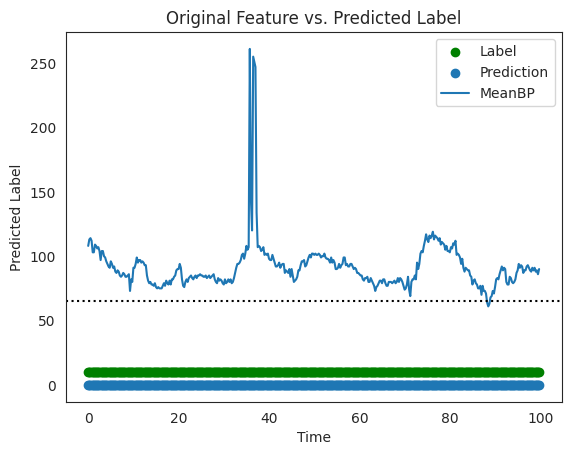

In [81]:
import matplotlib.pyplot as plt

start = 6400
end = 6800


p_X_train, p_X_test, p_y_train, p_y_test = train_test_split(data, labels, test_size=0.1, random_state=42, shuffle= False)
original_features_train, original_features_test = train_test_split(original_features, test_size=0.1, random_state=42, shuffle= False)
# make predictions on your test set
p_y_pred = model.predict(p_X_test)

# create a scatter plot of the feature vs. the predicted labels
# use the true labels as the color
x_axis = np.arange(0, (end-start))/4.

print(x_axis.shape)
print(p_X_test[start:end].shape)

plt.scatter(x_axis, p_y_test[start:end]*100+10, color='green')
plt.scatter(x_axis, p_y_pred[start:end]*100)
plt.plot(x_axis, original_features_test[start:end])
plt.axhline(y = 65., color = 'black', linestyle=":")

plt.legend(['Label', 'Prediction', 'MeanBP'])



# add labels and a title
plt.xlabel('Time')
plt.ylabel('Predicted Label')
plt.title('Original Feature vs. Predicted Label')

plt.show()

In [82]:
original_features_test[start:end]

array([108, 113, 114, 112, 103, 103, 109, 108, 106, 107, 104,  97, 104,
       104, 100,  99,  96,  94,  92,  91,  96,  94,  91,  92,  88,  87,
        89,  88,  85,  84,  85,  87,  86,  84,  84,  85,  86,  73,  82,
        80,  91,  91,  94,  99,  95,  97,  97,  95,  96,  95,  93,  93,
        85,  81,  79,  80,  78,  78,  77,  79,  76,  75,  76,  75,  75,
        75,  77,  79,  77,  81,  79,  78,  81,  78,  82,  82,  84,  85,
        89,  90,  90,  94,  91,  82,  77,  76,  80,  82,  80,  83,  84,
        85,  83,  82,  84,  85,  83,  85,  85,  86,  85,  85,  84,  84,
        85,  83,  84,  85,  83,  84,  85,  86,  82,  80,  79,  83,  81,
        82,  81,  79,  78,  82,  79,  80,  82,  80,  82,  79,  80,  83,
        87,  91,  94,  94,  95,  97, 101, 102,  98, 102, 108, 105, 107,
       261, 144, 120, 255, 251, 247, 134, 107, 108, 107, 104, 105, 107,
       101, 102, 101, 102,  98,  97,  97, 101,  98,  95,  92,  92,  93,
        95,  91,  93,  94,  94,  87,  89,  88,  87,  90,  84,  9

In [83]:
from sklearn.metrics import confusion_matrix


# compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# compute sensitivity and specificity'
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Sensitivity: 0.14884077635537726
Specificity: 0.9818128837425606


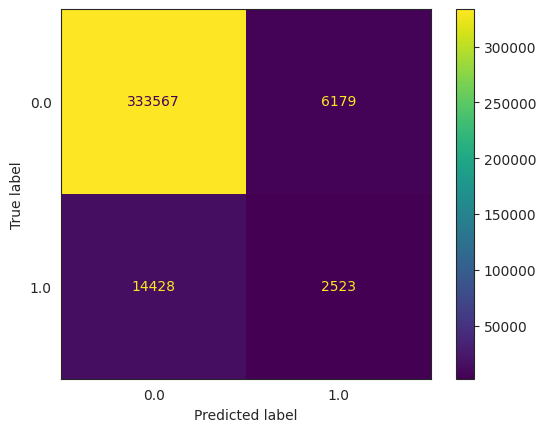

<Figure size 640x480 with 0 Axes>

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
sns.set_style("white")


predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

plt.show()

plt.savefig('confusion_matrix_'+str(shifts[shift_index])+'_isextern_'+str(kor)+'.png')

In [85]:
prob_pos = model.predict_proba(X_test)[:, 1]

In [86]:
from sklearn.calibration import calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

In [87]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, prob_pos)

# Calculate the AUROC score
auroc = roc_auc_score(y_test, prob_pos)


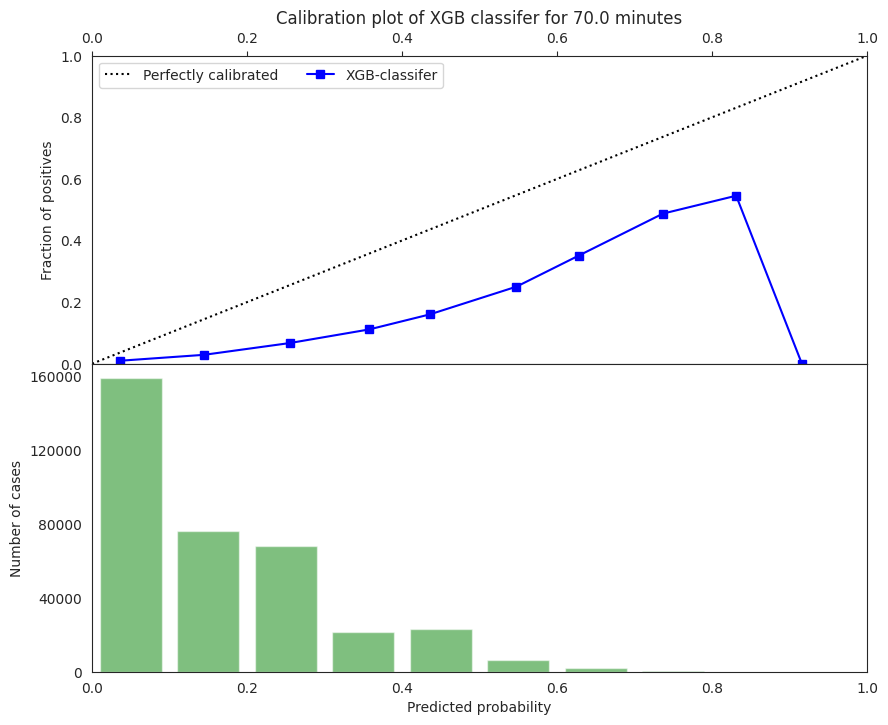

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

# Figure 1 for Calibration curve and Histogram
fig1 = plt.figure(figsize=(10, 8)) # Set the overall figure size

gs1 = plt.GridSpec(2, 1, height_ratios=[1, 1]) # Set height ratios to 1:1 for equal vertical size

# Calibration curve
ax1 = plt.subplot(gs1[0])
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")  
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % 'XGB-classifer', color='blue')
ax1.set_xlim([0, 1]) # Set x range to 0 to 1
ax1.set_ylim([0, 1]) # Set y range to 0 to 1
ax1.set_ylabel("Fraction of positives")
ax1.set_title('Calibration plot of XGB classifer for '+str(shifts[shift_index]/-4)+' minutes')
ax1.legend(loc="upper left")
ax1.xaxis.tick_top() # Move x-axis labels to top
ax1.xaxis.set_label_position('top') # Move x-axis label to top

# Position legend of plot 1 on x-axis
handles, labels_plot = ax1.get_legend_handles_labels()
ax1.legend(handles, labels_plot,  ncol=2)

# Histogram as an "inset" plot
ax2 = plt.subplot(gs1[1], sharex=ax1) # Sharing x-axis with first plot
hist, bins = np.histogram(prob_pos, bins=10, range=(0, 1))
width = (bins[1] - bins[0]) * 0.8
centers = (bins[:-1] + bins[1:]) / 2
ax2.bar(centers, hist, align='center', width=width, alpha=0.5, color='green', label='Histogram')
ax2.set_xlabel("Predicted probability") # Add x-axis label
ax2.set_ylabel("Number of cases")

ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.subplots_adjust(hspace=0)  



plt.savefig('XGB_preformance_'+str(shifts[shift_index])+'_isextern_'+str(kor)+'.png')
plt.show()

In [93]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_tprs = []
bootstrapped_auc = []

base_fpr = np.linspace(0, 1, 101)  # Fix the FPR values for interpolation

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(prob_pos), len(prob_pos))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    fpr_boot, tpr_boot, _ = roc_curve(y_test[indices], prob_pos[indices])
    bootstrapped_auc.append(auc(fpr_boot, tpr_boot))

    # Interpolate TPR for the fixed FPR value
    tpr_boot_interp = interp(base_fpr, fpr_boot, tpr_boot)
    bootstrapped_tprs.append(tpr_boot_interp)

# Convert list to a 2D array
bootstrapped_tprs = np.array(bootstrapped_tprs)

# Compute the lower and upper bound of the ROC curve
tprs_lower = np.percentile(bootstrapped_tprs, 2.5, axis=0)
tprs_upper = np.percentile(bootstrapped_tprs, 97.5, axis=0)

# Compute the lower and upper bound of the ROC AUC
auc_lower = np.percentile(bootstrapped_auc, 2.5)
auc_upper = np.percentile(bootstrapped_auc, 97.5)

print("Confidence interval for the ROC curve: [{:0.3f} - {:0.3}]".format(auc_lower, auc_upper))


KeyboardInterrupt



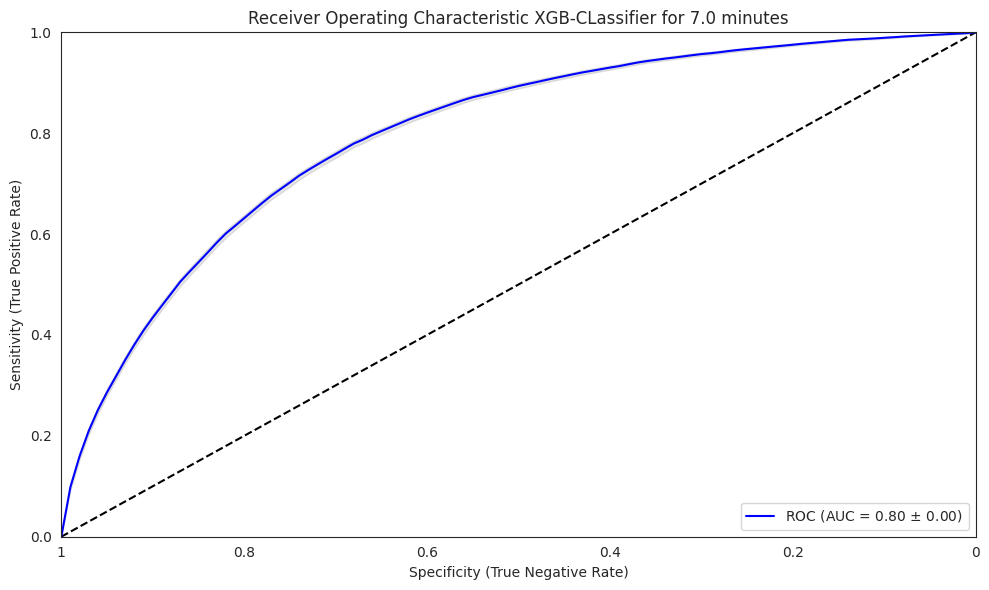

In [94]:
fig2 = plt.figure(figsize=(10, 6))

specificity = 1 - base_fpr  # Calculate Specificity (1 - False Positive Rate)

ax3 = plt.subplot(1, 1, 1)
ax3.plot([1, 0], [0, 1], 'k--')  # Invert x-axis
ax3.plot(specificity, np.median(bootstrapped_tprs, axis=0), label=r'ROC (AUC = %0.2f $\pm$ %0.2f)' % (auroc, (auc_upper-auc_lower)/2), color='blue')
ax3.fill_between(specificity, tprs_lower, tprs_upper, color='grey', alpha=0.2)
ax3.set_xlabel('Specificity (True Negative Rate)')
ax3.set_ylabel('Sensitivity (True Positive Rate)')
ax3.set_title('Receiver Operating Characteristic XGB-CLassifier for '+str(shifts[shift_index]/-4.)+' minutes')
ax3.legend(loc='lower right')
ax3.set_xlim([1, 0])  # Invert x-axis limits
ax3.set_ylim([0, 1])
ax3.set_xticks([1,0.8,0.6,0.4,0.2,0])  # Set x-axis tick locations
ax3.set_xticklabels([1,0.8,0.6,0.4,0.2,0])  # Set x-axis tick labels




plt.tight_layout()
plt.savefig('ROC_Curve_XGB_'+str(shifts[shift_index])+'_isextern_'+str(kor)+'.png')
plt.show()

In [91]:
'''
import numpy as np
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score
from sklearn.utils import resample
from tqdm import tqdm
# Define the number of bootstrap samples
n_bootstrap = 2000

# Create empty lists to store bootstrapped metrics
sensitivity_values = []
specificity_values = []
ppv_values = []
npv_values = []
auroc_values = []
accuracy_values = []



# Perform bootstrap resampling
for i in tqdm(range(n_bootstrap)):
    # Sample with replacement from the predictions
    indices = resample(range(len(y_pred)), replace=True)
    bootstrap_y_test = y_test[indices]
    bootstrap_y_pred = y_pred[indices]
    bootstrap_prob_pos = prob_pos[indices]

    # Calculate metrics for the bootstrap sample
    sensitivity = recall_score(bootstrap_y_test, bootstrap_y_pred)
    specificity = recall_score(bootstrap_y_test, bootstrap_y_pred, pos_label=0)
    ppv = precision_score(bootstrap_y_test, bootstrap_y_pred)
    npv = precision_score(bootstrap_y_test, bootstrap_y_pred, pos_label=0)
    auroc = roc_auc_score(bootstrap_y_test, bootstrap_prob_pos)
    accuracy = accuracy_score(bootstrap_y_test, bootstrap_y_pred)

    # Append the metric values to the lists
    sensitivity_values.append(sensitivity)
    specificity_values.append(specificity)
    ppv_values.append(ppv)
    npv_values.append(npv)
    auroc_values.append(auroc)
    accuracy_values.append(accuracy)

# Calculate confidence intervals
confidence_interval = 0.95
alpha = (1 - confidence_interval) / 2
lower_percentile = alpha * 100
upper_percentile = (1 - alpha) * 100

# Calculate confidence intervals for each metric
sensitivity_ci = np.percentile(sensitivity_values, [lower_percentile, upper_percentile])
specificity_ci = np.percentile(specificity_values, [lower_percentile, upper_percentile])
ppv_ci = np.percentile(ppv_values, [lower_percentile, upper_percentile])
npv_ci = np.percentile(npv_values, [lower_percentile, upper_percentile])
auroc_ci = np.percentile(auroc_values, [lower_percentile, upper_percentile])
accuracy_ci = np.percentile(accuracy_values, [lower_percentile, upper_percentile])


with open("metrics_XGB_"+str(shifts[shift_index])+'_isextern_'+str(kor)+".txt", "w") as file:
    file.write("Accuracy: {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(accuracy_values), accuracy_ci[0], accuracy_ci[1]))
    file.write("Sensitivity: {:.3f} ({:.3f}-{:.3f})\n".format(sensitivity, sensitivity_ci[0], sensitivity_ci[1]))
    file.write("Specificity: {:.3f} ({:.3f}-{:.3f})\n".format(specificity, specificity_ci[0], specificity_ci[1]))
    file.write("Positive Predictive Value (PPV): {:.3f} ({:.3f}-{:.3f})\n".format(ppv, ppv_ci[0], ppv_ci[1]))
    file.write("Negative Predictive Value (NPV): {:.3f} ({:.3f}-{:.3f})\n".format(npv, npv_ci[0], npv_ci[1]))
    file.write("Area Under the ROC Curve (AUROC): {:.3f} ({:.3f}-{:.3f})".format(auroc, auroc_ci[0], auroc_ci[1]))

'''


'\nimport numpy as np\nfrom sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score\nfrom sklearn.utils import resample\nfrom tqdm import tqdm\n# Define the number of bootstrap samples\nn_bootstrap = 2000\n\n# Create empty lists to store bootstrapped metrics\nsensitivity_values = []\nspecificity_values = []\nppv_values = []\nnpv_values = []\nauroc_values = []\naccuracy_values = []\n\n\n\n# Perform bootstrap resampling\nfor i in tqdm(range(n_bootstrap)):\n    # Sample with replacement from the predictions\n    indices = resample(range(len(y_pred)), replace=True)\n    bootstrap_y_test = y_test[indices]\n    bootstrap_y_pred = y_pred[indices]\n    bootstrap_prob_pos = prob_pos[indices]\n\n    # Calculate metrics for the bootstrap sample\n    sensitivity = recall_score(bootstrap_y_test, bootstrap_y_pred)\n    specificity = recall_score(bootstrap_y_test, bootstrap_y_pred, pos_label=0)\n    ppv = precision_score(bootstrap_y_test, bootstrap_y_pred)\n    npv = preci

In [98]:
import numpy as np
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score
from sklearn.utils import resample
from tqdm import tqdm
from joblib import Parallel, delayed

def compute_metrics(indices):
    bootstrap_y_test = y_test[indices]
    bootstrap_y_pred = y_pred[indices]
    bootstrap_prob_pos = prob_pos[indices]

    sensitivity = recall_score(bootstrap_y_test, bootstrap_y_pred)
    specificity = recall_score(bootstrap_y_test, bootstrap_y_pred, pos_label=0)
    ppv = precision_score(bootstrap_y_test, bootstrap_y_pred)
    npv = precision_score(bootstrap_y_test, bootstrap_y_pred, pos_label=0)
    auroc = roc_auc_score(bootstrap_y_test, bootstrap_prob_pos)
    accuracy = accuracy_score(bootstrap_y_test, bootstrap_y_pred)
    
    return sensitivity, specificity, ppv, npv, auroc, accuracy

# Parallel processing
n_jobs = -1  # this will use all the available cores
results = Parallel(n_jobs=n_jobs)(delayed(compute_metrics)(resample(range(len(y_pred)), replace=True)) for i in range(2000))

sensitivity_values, specificity_values, ppv_values, npv_values, auroc_values, accuracy_values = zip(*results)

# Calculate confidence intervals
confidence_interval = 0.95
alpha = (1 - confidence_interval) / 2
lower_percentile = alpha * 100
upper_percentile = (1 - alpha) * 100

# Calculate confidence intervals for each metric
sensitivity_ci = np.percentile(sensitivity_values, [lower_percentile, upper_percentile])
specificity_ci = np.percentile(specificity_values, [lower_percentile, upper_percentile])
ppv_ci = np.percentile(ppv_values, [lower_percentile, upper_percentile])
npv_ci = np.percentile(npv_values, [lower_percentile, upper_percentile])
auroc_ci = np.percentile(auroc_values, [lower_percentile, upper_percentile])
accuracy_ci = np.percentile(accuracy_values, [lower_percentile, upper_percentile])


with open("metrics_XGB_"+str(shifts[shift_index])+'_isextern_'+str(kor)+".txt", "w") as file:
    file.write("Accuracy: {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(accuracy_values), accuracy_ci[0], accuracy_ci[1]))
    file.write("Sensitivity: {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(sensitivity_values), sensitivity_ci[0], sensitivity_ci[1]))
    file.write("Specificity: {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(specificity_values), specificity_ci[0], specificity_ci[1]))
    file.write("Positive Predictive Value (PPV): {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(ppv_values), ppv_ci[0], ppv_ci[1]))
    file.write("Negative Predictive Value (NPV): {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(npv_values), npv_ci[0], npv_ci[1]))
    file.write("Area Under the ROC Curve (AUROC): {:.3f} ({:.3f}-{:.3f})".format(np.mean(auroc_values), auroc_ci[0], auroc_ci[1]))